In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing as prep
from sklearn.model_selection import train_test_split
from model import AugementedConvLSTM
import h5py
import itertools

In [2]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )
model.load_weights('convlstm_weights_pr_modified.h5')

2022-06-28 15:47:20.262516: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 15:47:26.775007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9631 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-28 15:47:26.796943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-28 15:47:26.800336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [3]:
def Process(i = 0, model = None, mask = [1,1,1,1,1], rf_idx = 1, end_index = 1000, show_plots = [1,1,1], Overwrite = False):
    def load_dataset():
        filepath = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data"
        rf = np.array(np.load(os.path.join(filepath,rf"r{rf_idx}.npy")))[:end_index,:,:]
        X = np.empty((7,end_index,129,135))
        X[0,:,:,:] = np.array(np.load(r"MIROC-ESM.npy"))[:end_index,:,:] if mask[0] else np.array(rf)
        X[1,:,:,:] = np.array(np.load(r"elev.npy"))[:end_index,:,:] if mask[1] else np.array(rf)
        X[2,:,:,:] = np.array(np.load(os.path.join(filepath,rf"rhum.npy")))[:end_index,:,:] if mask[2] else np.array(rf)
        X[3,:,:,:] = np.array(np.load(os.path.join(filepath,rf"pres.npy")))[:end_index,:,:] if mask[3] else np.array(rf)
        X[4,:,:,:] = np.array(np.load(os.path.join(filepath,rf"uwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[5,:,:,:] = np.array(np.load(os.path.join(filepath,rf"vwnd.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        X[6,:,:,:] = np.array(np.load(os.path.join(filepath,rf"omega.npy")))[:end_index,:,:] if mask[4] else np.array(rf)
        # print(X.shape)
        Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
        return X, Y
    def normalize(data):
        data = data - data.mean()
        data = data / data.std()
        return data
    def data_generator(X,Y):
        time_steps = 4
        batch_size1 = 1
        generator = prep.sequence.TimeseriesGenerator(
            X, 
            Y.reshape(-1, 129, 135, 1),
            length=time_steps, 
            batch_size=batch_size1
            )
        return generator
    def set_data(X, Y):
        X_normalized = np.zeros((7, end_index, 129, 135))
        for i in range(7):
            X_normalized[i,] = normalize(X[i,])
        Y_normalized = normalize(Y)
        # print("Mean of GCM Data: ",X[0,].mean())
        # print("Variance of GCM Data: ",X[0,].std(),end="\n")
        # print("Mean of Obseved Data: ",Y.mean())
        # print("Variance of Obseved Data: ",Y.std(),end="\n")
        std_observed = Y.std()
        # X = X_normalized.transpose(1,2,3,0)
        # Y = Y_normalized.reshape(-1,129, 135, 1)
        return data_generator(X_normalized.transpose(1,2,3,0), Y_normalized.reshape(-1,129, 135, 1))
    
    if not Overwrite:
        try:
            Y = np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]
            yy_hat = np.load(rf"Data/modified_yy_hat_{i}.npy")
            Y = normalize(Y).reshape(-1,129, 135, 1)
        except:
            X, Y = load_dataset()
            generator = set_data(X, Y)
            yy_hat = model.predict(generator)
            np.save(rf"Data/modified_yy_hat_{i}.npy", yy_hat)
            del X, generator
    else:
        X, Y = load_dataset()
        generator = set_data(X, Y)
        yy_hat = model.predict(generator)
        np.save(rf"Data/modified_yy_hat_{i}.npy", yy_hat)
        del X, generator
    
    calc = []

    Y_hat = np.array(yy_hat).reshape(-1,129,135)
    data = np.array(np.mean(Y_hat, axis = 0))
    print(f"Y_hat (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    if show_plots[0]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.mean((Y_hat*Y_Obs.std())+Y_Obs.mean(), axis = 0))
    print(f"Y_hat (Scaled) (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    data[indices] = np.nan
    if show_plots[1]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices

    Y_Obs = np.array(np.load(rf"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/05_Random_Field_India/Data/IMD.npy")[:,:end_index,:,:]).reshape(-1,129,135)[4:]
    Y_hat = np.array(yy_hat.reshape(-1,129,135))
    data = np.array(np.sqrt(np.sum(np.square(((Y_hat*Y_Obs.std())+Y_Obs.mean()) - Y_Obs), axis = 0)/Y_hat.shape[0]))
    print(f"RMSE (Min, Max, Mean) = ({round(np.nanmin(data),3)}, {round(np.nanmax(data),3)}, {round(np.nanmean(data),3)}) mm/day")
    calc += [round(np.nanmin(data),3), round(np.nanmax(data),3), round(np.nanmean(data),3)]
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM.npy"
    mask = np.load(FileName)
    indices = np.where(mask == 0)
    data[indices] = np.nan
    threshold_99 = np.nanpercentile(data, 99)
    indices = np.where(data > threshold_99)
    data[indices] = np.nan
    if show_plots[2]:
        fig,ax = plt.subplots(1,2, figsize = (20,10))
        sns.heatmap(np.flip(data, axis = 0), cmap = 'rainbow', ax =ax[0])
        ax[0].axis('off')
        ax[1].boxplot(data[~np.isnan(data)], vert = False)
        plt.show()
        del fig, ax
    del Y_hat, Y_Obs, data, FileName, mask, indices, threshold_99

    return calc
mask_calc = {}

In [4]:
mask_list = [ # Pr, elev, rh, p, wnd
    [1,1,1,1,1], 
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,0,1],
    [0,1,0,1,1],
    [0,1,1,0,0],
    [0,1,0,0,1],
    [0,1,0,1,0]
]

In [ ]:
# for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
#     print(idx, i)
#     mask_calc[str(i)]= Process(
#         i = idx, 
#         model = model, 
#         mask = i, 
#         rf_idx = 1, 
#         end_index = 365,
#         show_plots = [0,0,0],
#         Overwrite = False
#         )
#     print("*****************************************************************")

In [5]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,0],
        Overwrite = False
        )
    print("*****************************************************************")

0 [1, 1, 1, 1, 1]


2022-06-28 12:38:07.237704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-28 12:38:10.328415: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-28 12:38:11.883696: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Y_hat (Min, Max, Mean) = (-0.21400000154972076, 1.069000005722046, -0.050999999046325684) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3720000088214874, 7.205999851226807, 0.593999981880188) mm/day
RMSE (Min, Max, Mean) = (0.036, 55.649, 3.312) mm/day
*****************************************************************
1 [1, 0, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.21199999749660492, 1.0759999752044678, -0.039000000804662704) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.36000001430511475, 7.250999927520752, 0.6600000262260437) mm/day
RMSE (Min, Max, Mean) = (0.049, 56.027, 3.416) mm/day
*****************************************************************
2 [1, 1, 0, 1, 1]
Y_hat (Min, Max, Mean) = (-0.2029999941587448, 0.6669999957084656, -0.06499999761581421) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.30799999833106995, 4.830999851226807, 0.5070000290870667) mm/day
RMSE (Min, Max, Mean) = (0.053, 56.445, 3.318) mm/day
*****************************************************************
3 [1, 

In [4]:
mask_list = [ # Pr, elev, rh, p, wnd
    [1,1,1,1,1], 
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],
    [0,1,1,1,0],
    [0,1,1,0,1],
    [0,1,0,1,1],
    [0,1,1,0,0],
    [0,1,0,0,1],
    [0,1,0,1,0], ###############
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,0,1,0],
    [0,0,0,0,1],
    [1,0,0,0,0],
    [0,0,0,0,0]
]

In [5]:
for idx, i in itertools.islice(enumerate(mask_list),15,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,0],
        Overwrite = False
        )
    print("*****************************************************************")

15 [1, 0, 0, 0, 0]


2022-06-28 15:49:07.831543: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-28 15:49:09.130180: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-28 15:49:09.813649: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Y_hat (Min, Max, Mean) = (-0.19099999964237213, -0.11400000005960464, -0.13199999928474426) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.23399999737739563, 0.22200000286102295, 0.11299999803304672) mm/day
RMSE (Min, Max, Mean) = (0.051, 57.92, 3.07) mm/day
*****************************************************************
16 [0, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.2029999941587448, -0.11999999731779099, -0.13300000131130219) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.30300000309944153, 0.18199999630451202, 0.11100000143051147) mm/day
RMSE (Min, Max, Mean) = (0.047, 57.908, 3.064) mm/day
*****************************************************************


0 [1, 1, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.21400000154972076, 1.069000005722046, -0.050999999046325684) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3720000088214874, 7.205999851226807, 0.593999981880188) mm/day
RMSE (Min, Max, Mean) = (0.036, 55.649, 3.312) mm/day


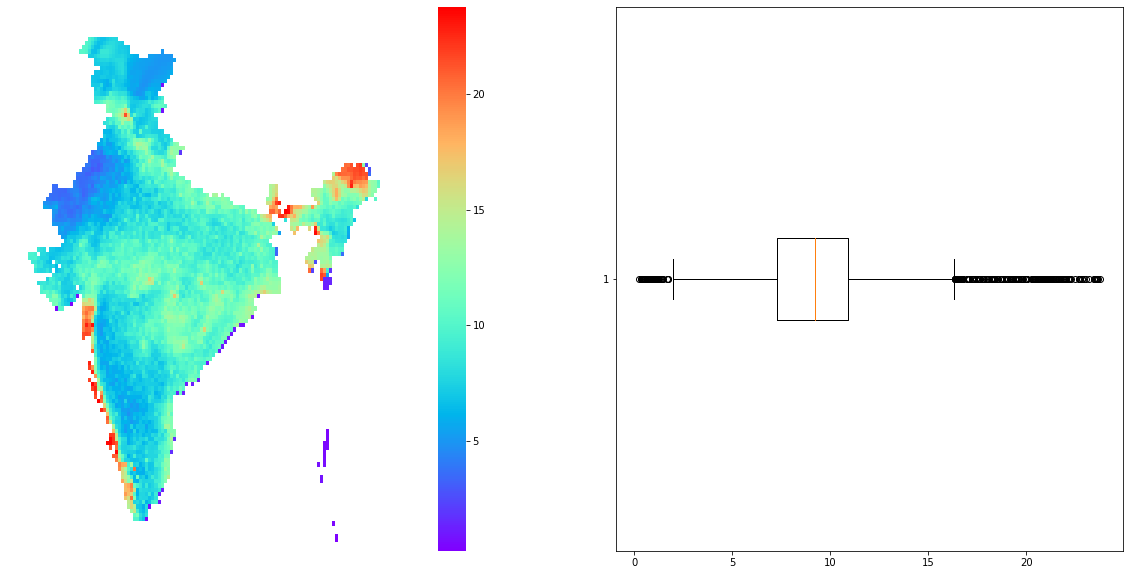

*****************************************************************
1 [1, 0, 1, 1, 1]
Y_hat (Min, Max, Mean) = (-0.21199999749660492, 1.0759999752044678, -0.039000000804662704) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.36000001430511475, 7.250999927520752, 0.6600000262260437) mm/day
RMSE (Min, Max, Mean) = (0.049, 56.027, 3.416) mm/day


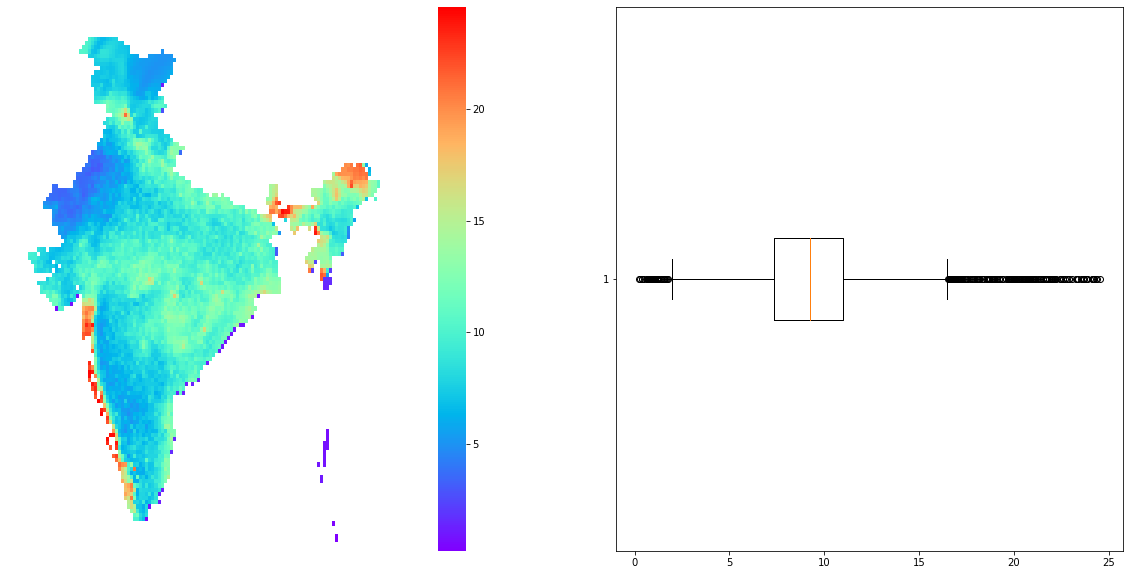

*****************************************************************
2 [1, 1, 0, 1, 1]
Y_hat (Min, Max, Mean) = (-0.2029999941587448, 0.6669999957084656, -0.06499999761581421) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.30799999833106995, 4.830999851226807, 0.5070000290870667) mm/day
RMSE (Min, Max, Mean) = (0.053, 56.445, 3.318) mm/day


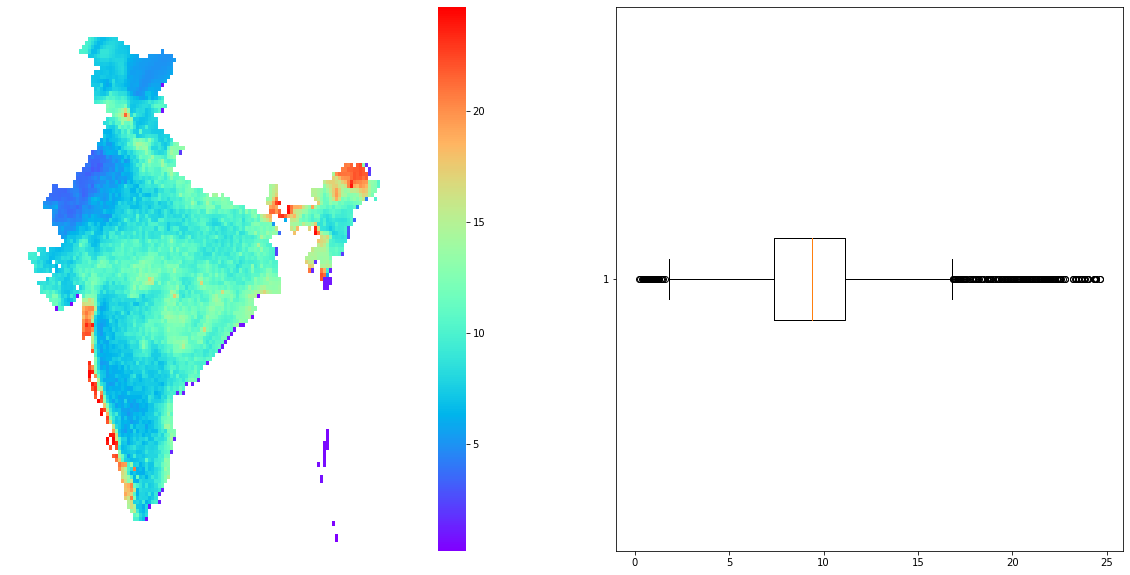

*****************************************************************
3 [1, 1, 1, 0, 1]
Y_hat (Min, Max, Mean) = (-0.1979999989271164, 0.7609999775886536, -0.026000000536441803) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.2750000059604645, 5.388000011444092, 0.7400000095367432) mm/day
RMSE (Min, Max, Mean) = (0.083, 55.865, 3.699) mm/day


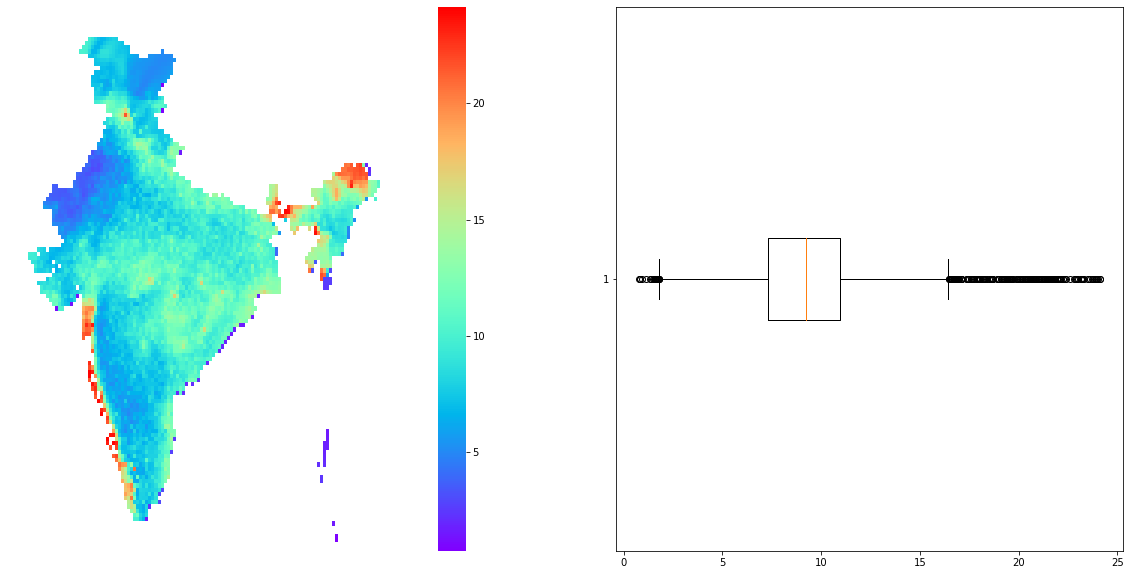

*****************************************************************
4 [1, 1, 1, 1, 0]
Y_hat (Min, Max, Mean) = (-0.2070000022649765, 0.1289999932050705, -0.1120000034570694) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3310000002384186, 1.656000018119812, 0.23399999737739563) mm/day
RMSE (Min, Max, Mean) = (0.043, 57.592, 3.19) mm/day


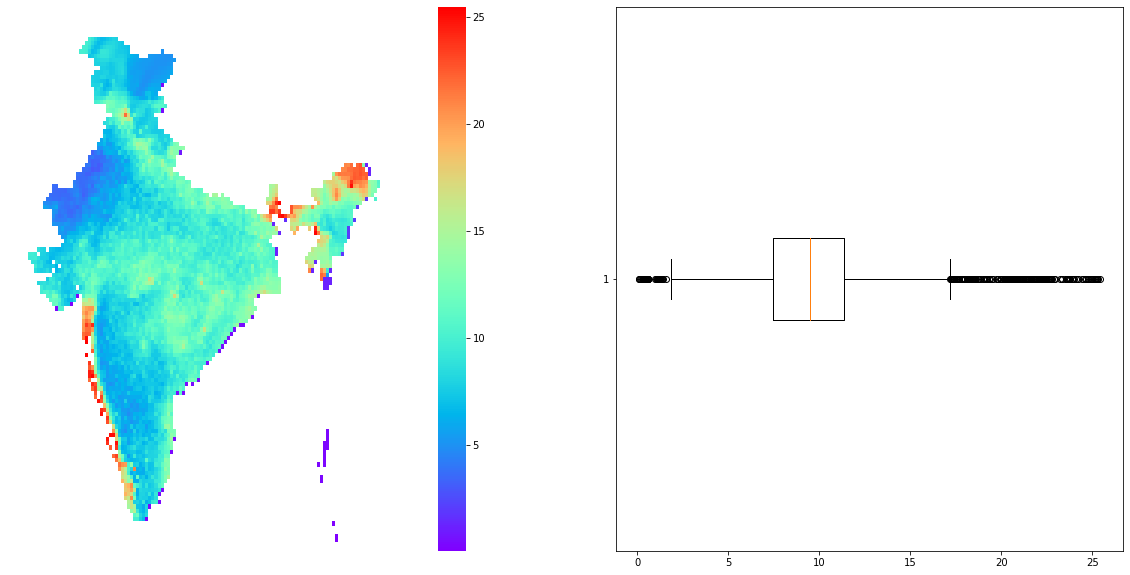

*****************************************************************
5 [0, 1, 1, 1, 0]
Y_hat (Min, Max, Mean) = (-0.20800000429153442, 0.20800000429153442, -0.07800000160932541) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3370000123977661, 2.121000051498413, 0.43299999833106995) mm/day
RMSE (Min, Max, Mean) = (0.045, 57.201, 3.32) mm/day


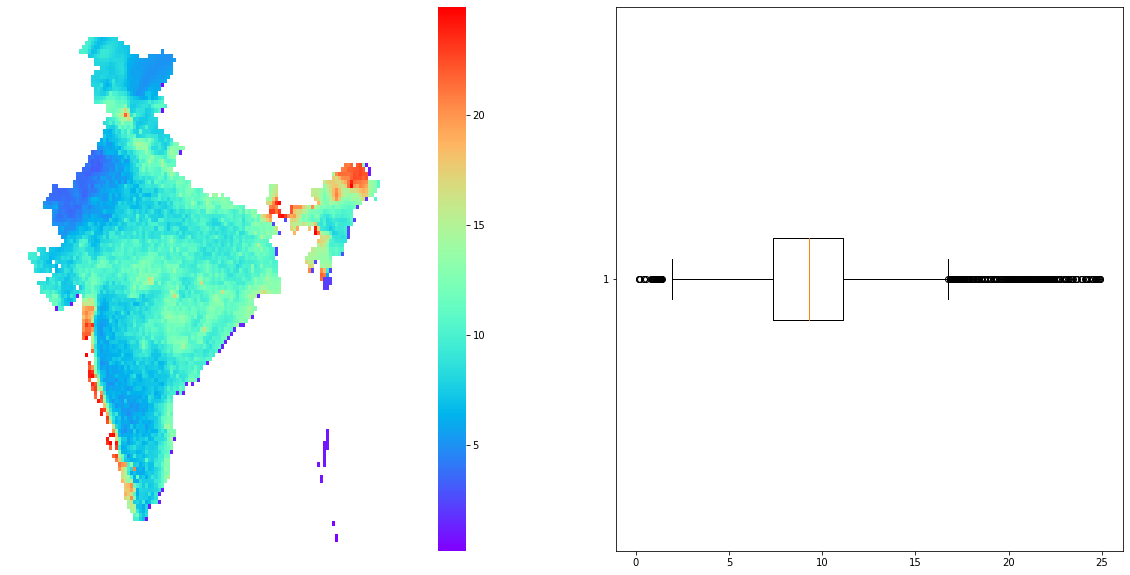

*****************************************************************
6 [0, 1, 1, 0, 1]
Y_hat (Min, Max, Mean) = (-0.19200000166893005, 1.1699999570846558, 0.017999999225139618) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.23899999260902405, 7.806000232696533, 0.9980000257492065) mm/day
RMSE (Min, Max, Mean) = (0.094, 55.536, 3.755) mm/day


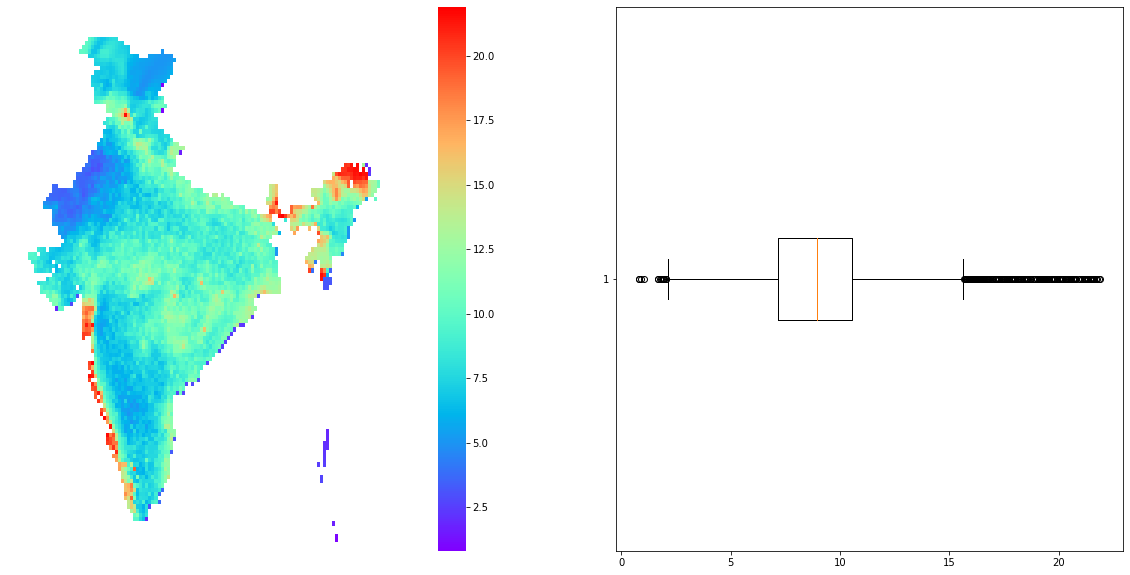

*****************************************************************
7 [0, 1, 0, 1, 1]
Y_hat (Min, Max, Mean) = (-0.20499999821186066, 0.7990000247955322, -0.08699999749660492) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3199999928474426, 5.616000175476074, 0.38100001215934753) mm/day
RMSE (Min, Max, Mean) = (0.039, 56.336, 3.111) mm/day


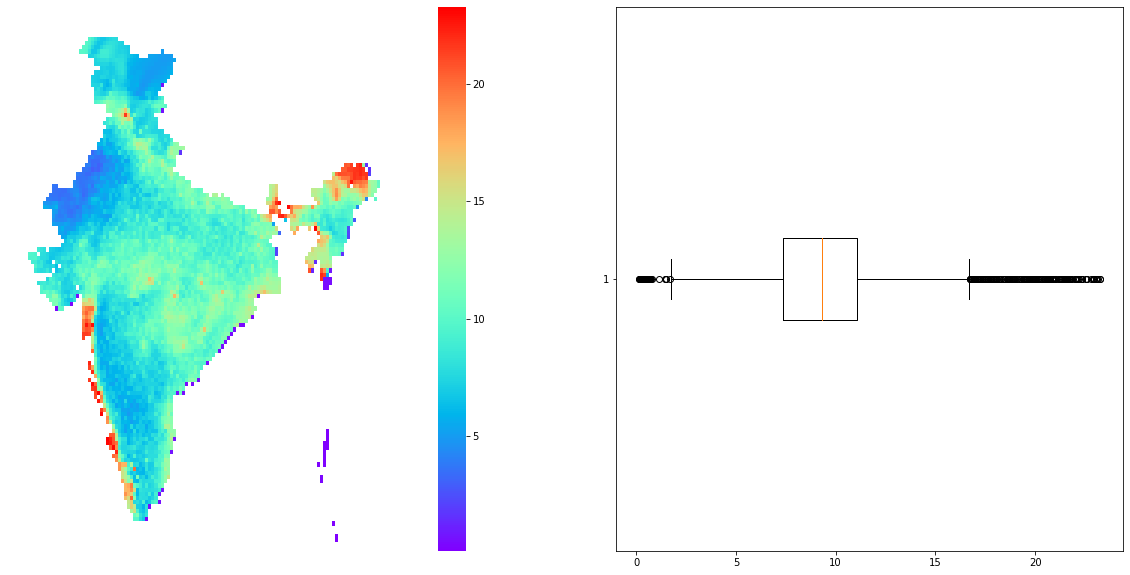

*****************************************************************
8 [0, 1, 1, 0, 0]
Y_hat (Min, Max, Mean) = (-0.20100000500679016, 0.10199999809265137, -0.06499999761581421) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.29100000858306885, 1.4930000305175781, 0.5099999904632568) mm/day
RMSE (Min, Max, Mean) = (0.069, 57.388, 3.567) mm/day


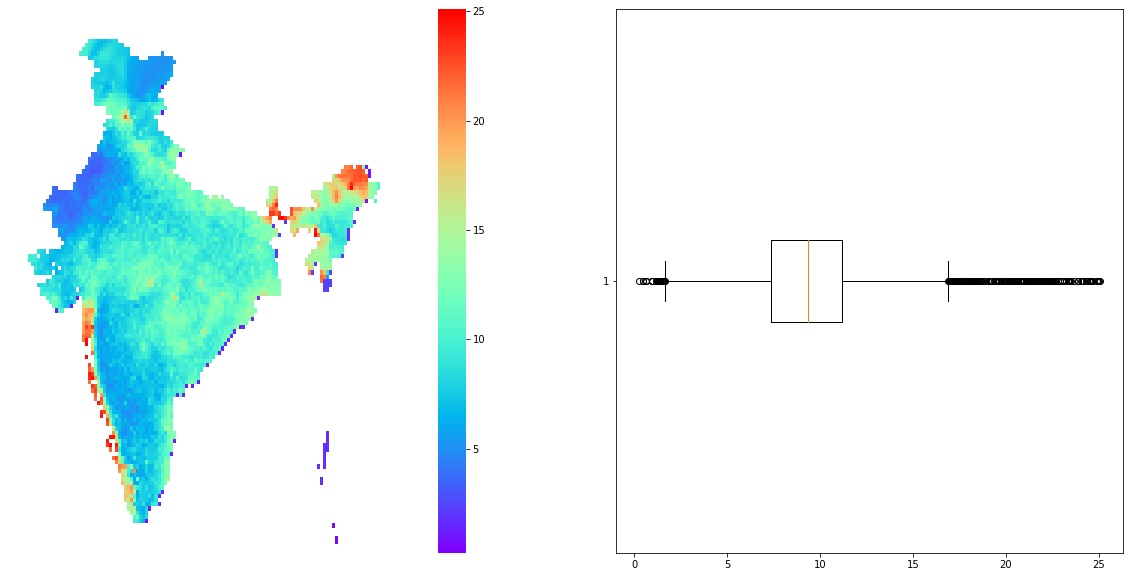

*****************************************************************
9 [0, 1, 0, 0, 1]
Y_hat (Min, Max, Mean) = (-0.19699999690055847, 0.7860000133514404, -0.09399999678134918) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.2720000147819519, 5.533999919891357, 0.3409999907016754) mm/day
RMSE (Min, Max, Mean) = (0.057, 56.698, 3.211) mm/day


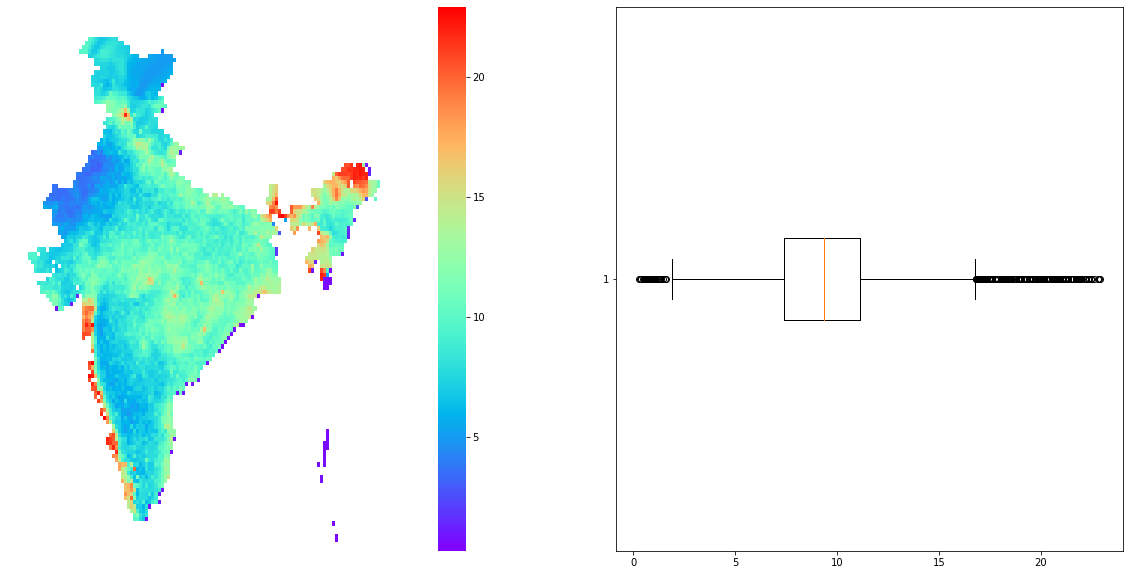

*****************************************************************
10 [0, 1, 0, 1, 0]
Y_hat (Min, Max, Mean) = (-0.2150000035762787, 0.017000000923871994, -0.13300000131130219) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3779999911785126, 0.9940000176429749, 0.10700000077486038) mm/day
RMSE (Min, Max, Mean) = (0.052, 57.855, 3.059) mm/day


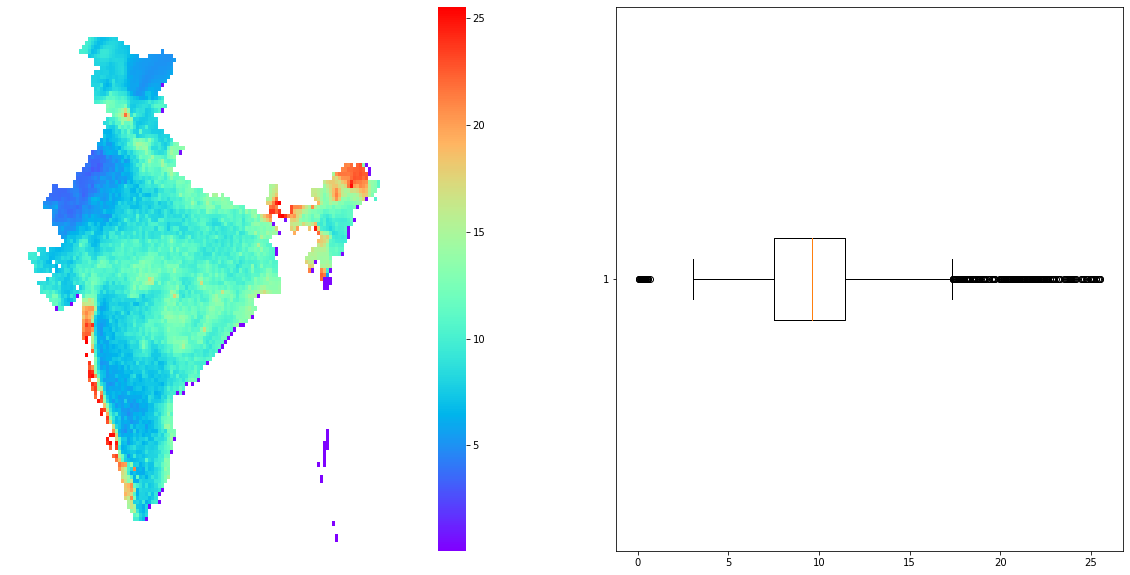

*****************************************************************
11 [0, 1, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.20900000631809235, -0.06499999761581421, -0.1420000046491623) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.33799999952316284, 0.5099999904632568, 0.05400000140070915) mm/day
RMSE (Min, Max, Mean) = (0.052, 57.928, 3.074) mm/day


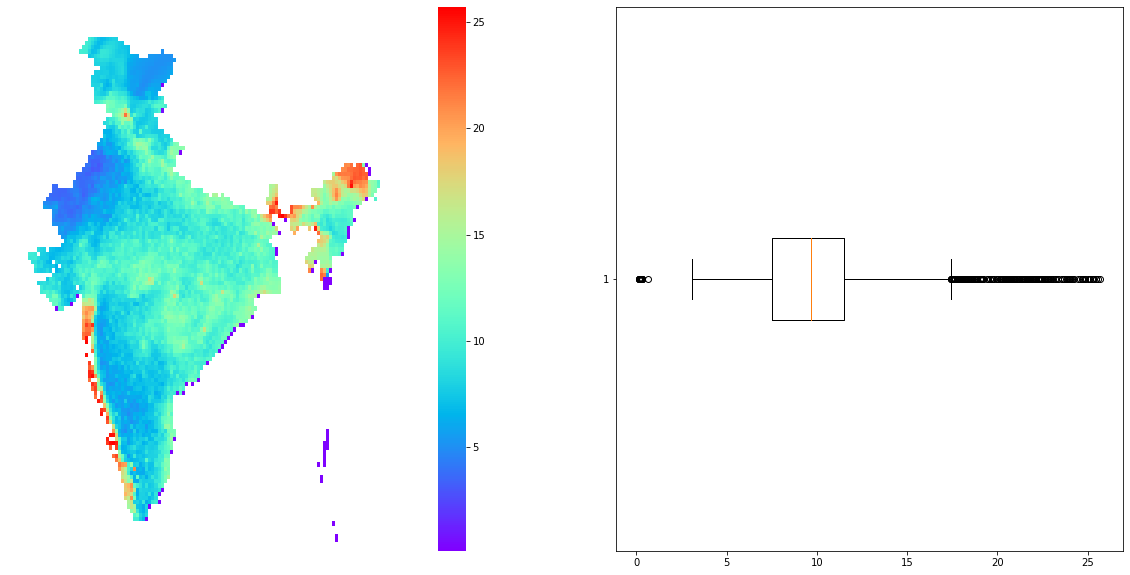

*****************************************************************
12 [0, 0, 1, 0, 0]
Y_hat (Min, Max, Mean) = (-0.20499999821186066, 0.296999990940094, 0.009999999776482582) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.3149999976158142, 2.6489999294281006, 0.953000009059906) mm/day
RMSE (Min, Max, Mean) = (0.058, 56.942, 3.889) mm/day


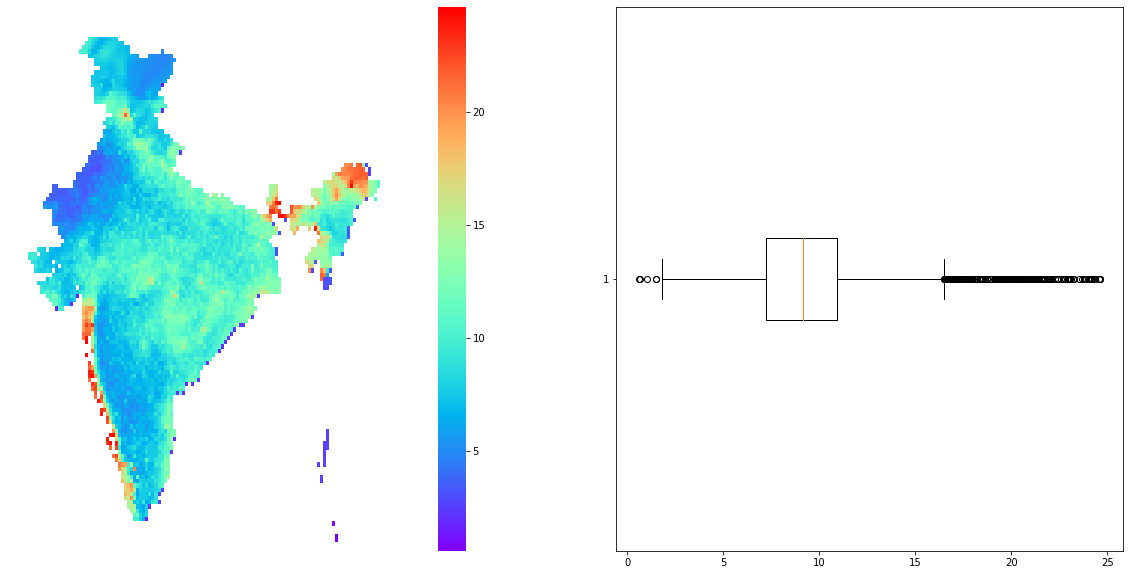

*****************************************************************
13 [0, 0, 0, 1, 0]
Y_hat (Min, Max, Mean) = (-0.22100000083446503, 0.1120000034570694, -0.12999999523162842) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.4099999964237213, 1.5540000200271606, 0.125) mm/day
RMSE (Min, Max, Mean) = (0.031, 57.779, 3.028) mm/day


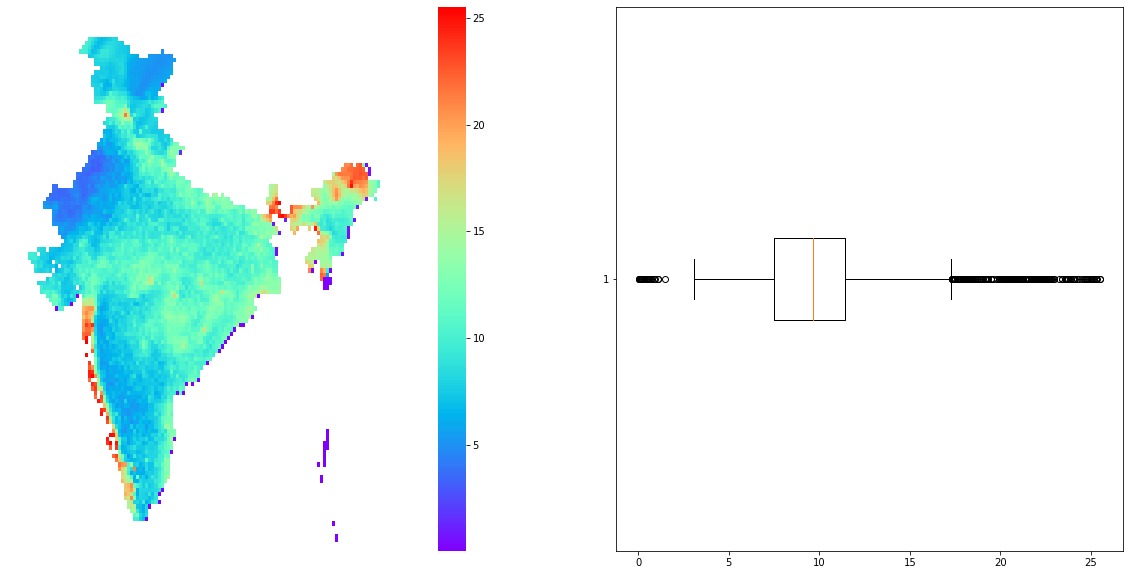

*****************************************************************
14 [0, 0, 0, 0, 1]
Y_hat (Min, Max, Mean) = (-0.20900000631809235, 0.671999990940094, -0.05999999865889549) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.34200000762939453, 4.86299991607666, 0.5379999876022339) mm/day
RMSE (Min, Max, Mean) = (0.046, 56.438, 3.242) mm/day


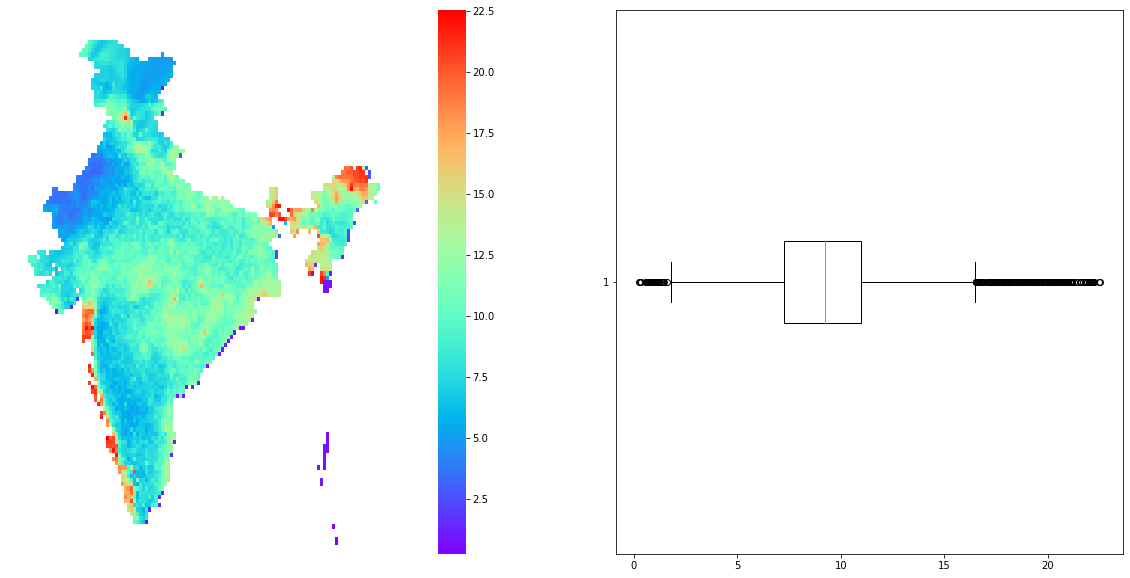

*****************************************************************
15 [1, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.19099999964237213, -0.11400000005960464, -0.13199999928474426) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.23399999737739563, 0.22200000286102295, 0.11299999803304672) mm/day
RMSE (Min, Max, Mean) = (0.051, 57.92, 3.07) mm/day


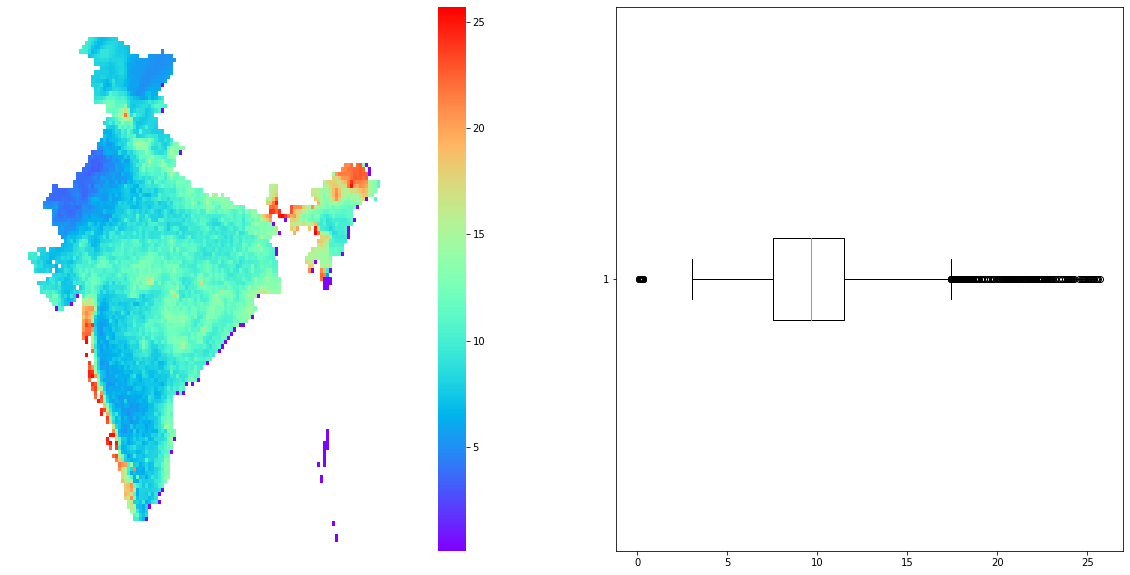

*****************************************************************
16 [0, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.2029999941587448, -0.11999999731779099, -0.13300000131130219) mm/day
Y_hat (Scaled) (Min, Max, Mean) = (-0.30300000309944153, 0.18199999630451202, 0.11100000143051147) mm/day
RMSE (Min, Max, Mean) = (0.047, 57.908, 3.064) mm/day


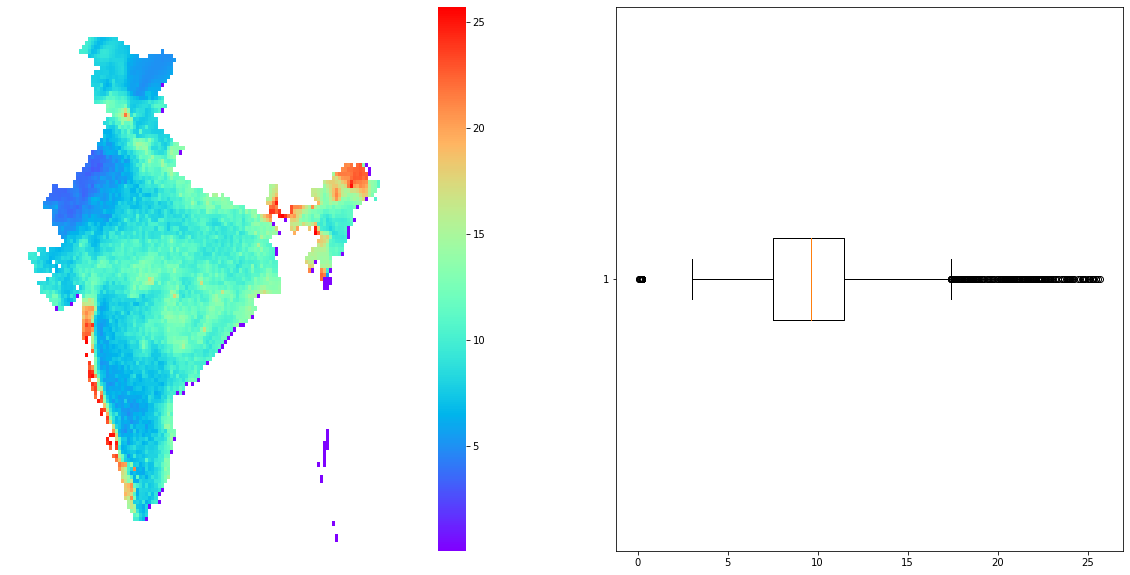

*****************************************************************


In [7]:
for idx, i in itertools.islice(enumerate(mask_list),0,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [0,0,1],
        Overwrite = False
        )
    print("*****************************************************************")

16 [0, 0, 0, 0, 0]
Y_hat (Min, Max, Mean) = (-0.2029999941587448, -0.11999999731779099, -0.13300000131130219) mm/day


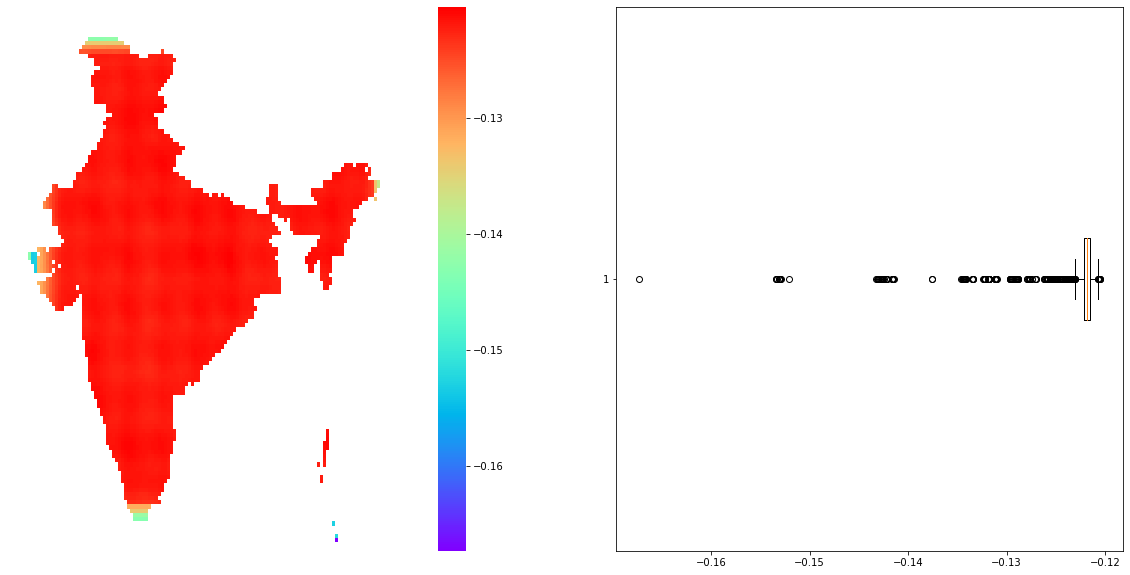

Y_hat (Scaled) (Min, Max, Mean) = (-0.30300000309944153, 0.18199999630451202, 0.11100000143051147) mm/day


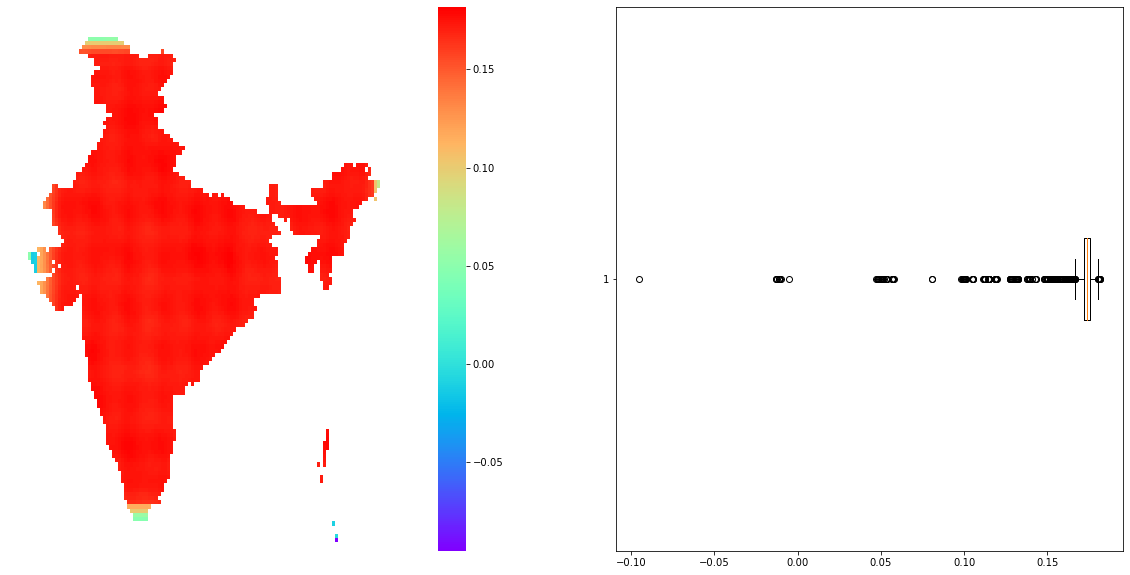

RMSE (Min, Max, Mean) = (0.047, 57.908, 3.064) mm/day


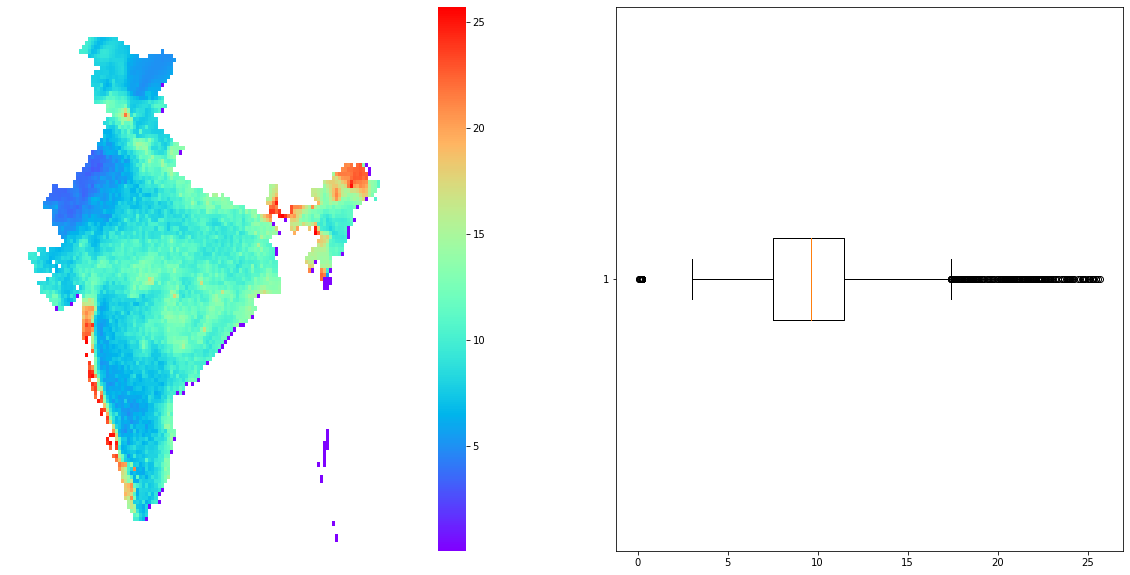

*****************************************************************


In [8]:
for idx, i in itertools.islice(enumerate(mask_list),16,None,1):
    print(idx, i)
    mask_calc[str(i)]= Process(
        i = idx, 
        model = model, 
        mask = i, 
        rf_idx = 1, 
        end_index = 21185,
        show_plots = [1,1,1],
        Overwrite = False
        )
    print("*****************************************************************")